In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Define paths
base_path = '/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset'
categories = ['COVID', 'Normal', 'Lung_Opacity', 'Viral Pneumonia']

# Load images and masks
def load_data():
    images = []
    masks = []
    labels = []
    
    for i, category in enumerate(categories):
        img_path = os.path.join(base_path, category, 'images')
        mask_path = os.path.join(base_path, category, 'masks')
        
        for img_file in os.listdir(img_path)[:500]:  # Load subset for demo
            if img_file.endswith('.png'):
                # Load image
                img = cv2.imread(os.path.join(img_path, img_file), cv2.IMREAD_GRAYSCALE)
                img = cv2.resize(img, (256, 256))
                img = img / 255.0  # Normalize
                
                # Load corresponding mask if exists
                mask_file = os.path.join(mask_path, img_file)
                if os.path.exists(mask_file):
                    mask = cv2.imread(mask_file, cv2.IMREAD_GRAYSCALE)
                    mask = cv2.resize(mask, (256, 256))
                    mask = mask / 255.0
                else:
                    mask = np.zeros_like(img)
                
                images.append(img)
                masks.append(mask)
                labels.append(i)
    
    return np.array(images), np.array(masks), to_categorical(np.array(labels))

X, y_masks, y_labels = load_data()

# Split data
X_train, X_test, y_train_masks, y_test_masks, y_train_labels, y_test_labels = train_test_split(
    X, y_masks, y_labels, test_size=0.2, random_state=42
)

# Add channel dimension
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)
y_train_masks = np.expand_dims(y_train_masks, axis=-1)
y_test_masks = np.expand_dims(y_test_masks, axis=-1)

2025-04-24 14:11:29.492919: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745503889.701910      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745503889.760377      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [9]:
# Print shapes of all data arrays
print("=== Data Shapes ===")
print(f"X_train shape: {X_train.shape}")  # (num_samples, height, width, channels)
print(f"y_train_masks shape: {y_train_masks.shape}")
print(f"y_train_labels shape: {y_train_labels.shape}\n")

print(f"X_test shape: {X_test.shape}")
print(f"y_test_masks shape: {y_test_masks.shape}")
print(f"y_test_labels shape: {y_test_labels.shape}\n")

# Calculate and print number of samples
print("=== Sample Counts ===")
print(f"Total training samples: {X_train.shape[0]}")
print(f"Total test samples: {X_test.shape[0]}")
print(f"Total samples: {X_train.shape[0] + X_test.shape[0]}\n")

# Print category distribution
print("=== Category Distribution ===")
print("Training set:")
for i, category in enumerate(categories):
    count = np.sum(np.argmax(y_train_labels, axis=1) == i)
    print(f"{category}: {count} samples")
    
print("\nTest set:")
for i, category in enumerate(categories):
    count = np.sum(np.argmax(y_test_labels, axis=1) == i)
    print(f"{category}: {count} samples")

=== Data Shapes ===
X_train shape: (1600, 256, 256, 1)
y_train_masks shape: (1600, 256, 256, 1)
y_train_labels shape: (1600, 4)

X_test shape: (400, 256, 256, 1)
y_test_masks shape: (400, 256, 256, 1)
y_test_labels shape: (400, 4)

=== Sample Counts ===
Total training samples: 1600
Total test samples: 400
Total samples: 2000

=== Category Distribution ===
Training set:
COVID: 396 samples
Normal: 405 samples
Lung_Opacity: 412 samples
Viral Pneumonia: 387 samples

Test set:
COVID: 104 samples
Normal: 95 samples
Lung_Opacity: 88 samples
Viral Pneumonia: 113 samples


Build Segmentation Model

We'll use a U-Net architecture for segmentation:

In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate

def unet_model(input_size=(256, 256, 1)):
    inputs = Input(input_size)
    
    # Downsample
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    # Bottleneck
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    
    # Upsample
    up4 = UpSampling2D(size=(2, 2))(conv3)
    up4 = Conv2D(128, 2, activation='relu', padding='same')(up4)
    merge4 = concatenate([conv2, up4], axis=3)
    conv4 = Conv2D(128, 3, activation='relu', padding='same')(merge4)
    conv4 = Conv2D(128, 3, activation='relu', padding='same')(conv4)
    
    up5 = UpSampling2D(size=(2, 2))(conv4)
    up5 = Conv2D(64, 2, activation='relu', padding='same')(up5)
    merge5 = concatenate([conv1, up5], axis=3)
    conv5 = Conv2D(64, 3, activation='relu', padding='same')(merge5)
    conv5 = Conv2D(64, 3, activation='relu', padding='same')(conv5)
    
    # Output
    outputs = Conv2D(1, 1, activation='sigmoid')(conv5)
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

model = unet_model()
model.summary()

I0000 00:00:1745503934.226632      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 64)   │            640 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 64)   │         36,928 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 64)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 128)  │        147,584 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 128)    │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 64, 64, 256)    │        590,080 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d             │ (None, 128, 128, 256)  │              0 │ conv2d_5[0][0]         │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 128, 128, 128)  │        131,200 │ up_sampling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 128, 128, 256)  │              0 │ conv2d_3[0][0],        │
│                           │                        │                │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 128, 128, 128)  │        295,040 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 128, 128, 128)  │        147,584 │ conv2d_7[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d_1           │ (None, 256, 256, 128)  │              0 │ conv2d_8[0][0]         │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 256, 256, 64)   │         32,832 │ up_sampling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 256, 256, 128)  │              0 │ conv2d_1[0][0],        │
│ (Concatenate)        

 Total params: 1,861,697 (7.10 MB)

 Trainable params: 1,861,697 (7.10 MB)

 Non-trainable params: 0 (0.00 B)

Train the Model

In [3]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

callbacks = [
    ModelCheckpoint('best_model.h5.keras', save_best_only=True),
]

history = model.fit(
    X_train, y_train_masks,
    validation_data=(X_test, y_test_masks),
    batch_size=32,
    epochs=40,
    callbacks=callbacks
)

Epoch 1/40


I0000 00:00:1745503943.196795      93 service.cc:148] XLA service 0x7f6a70045e60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745503943.197489      93 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1745503944.017646      93 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-04-24 14:12:44.762767: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng2{k2=3,k3=0} for conv (f32[32,128,256,256]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,64,256,256]{3,2,1,0}, f32[64,128,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-04-24 14:12:44.762935: E 

50/50 ━━━━━━━━━━━━━━━━━━━━ 101s 1s/step - accuracy: 0.7185 - loss: 0.6517 - val_accuracy: 0.7584 - val_loss: 0.4190
Epoch 2/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 28s 559ms/step - accuracy: 0.7892 - loss: 0.3828 - val_accuracy: 0.8135 - val_loss: 0.3850
Epoch 3/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 28s 559ms/step - accuracy: 0.8657 - loss: 0.3117 - val_accuracy: 0.8973 - val_loss: 0.2536
Epoch 4/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 28s 559ms/step - accuracy: 0.9052 - loss: 0.2364 - val_accuracy: 0.9198 - val_loss: 0.2010
Epoch 5/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 28s 559ms/step - accuracy: 0.9227 - loss: 0.1966 - val_accuracy: 0.9312 - val_loss: 0.1772
Epoch 6/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 28s 559ms/step - accuracy: 0.9294 - loss: 0.1805 - val_accuracy: 0.9362 - val_loss: 0.1710
Epoch 7/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 28s 558ms/step - accuracy: 0.9375 - loss: 0.1609 - val_accuracy: 0.9488 - val_loss: 0.1391
Epoch 8/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 28s 556ms/step - accuracy: 0.9496 - loss: 0.1315 - val_accuracy: 0.9445 

Evaluate and Compare Masks

E0000 00:00:1745505127.558765      94 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745505127.791336      94 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745505128.349055      94 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745505128.604475      94 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


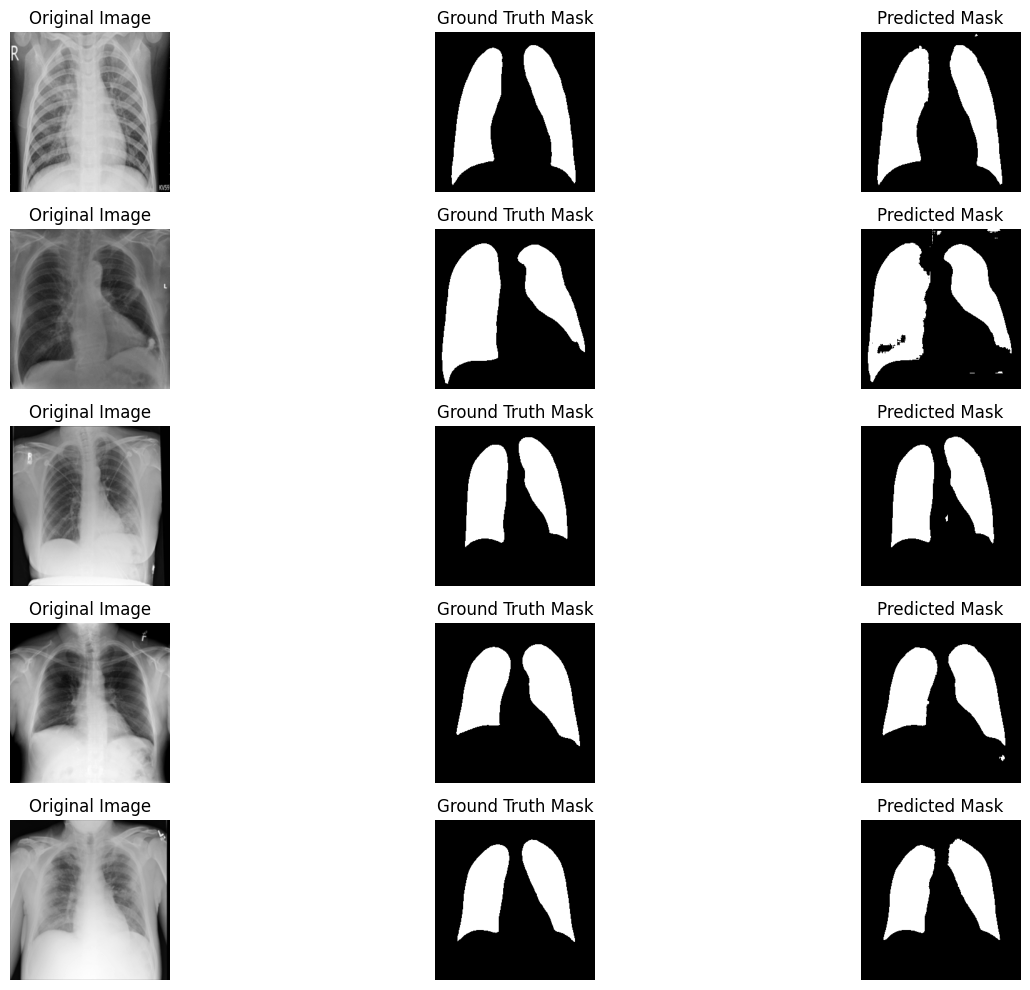

In [4]:
def compare_masks(model, X_test, y_test_masks, num_samples=5):
    pred_masks = model.predict(X_test[:num_samples])
    
    plt.figure(figsize=(15, 10))
    for i in range(num_samples):
        # Original Image
        plt.subplot(num_samples, 3, i*3 + 1)
        plt.imshow(X_test[i].squeeze(), cmap='gray')
        plt.title("Original Image")
        plt.axis('off')
        
        # Ground Truth Mask
        plt.subplot(num_samples, 3, i*3 + 2)
        plt.imshow(y_test_masks[i].squeeze(), cmap='gray')
        plt.title("Ground Truth Mask")
        plt.axis('off')
        
        # Predicted Mask
        plt.subplot(num_samples, 3, i*3 + 3)
        plt.imshow((pred_masks[i].squeeze() > 0.5).astype(np.uint8), cmap='gray')
        plt.title("Predicted Mask")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

compare_masks(model, X_test, y_test_masks)

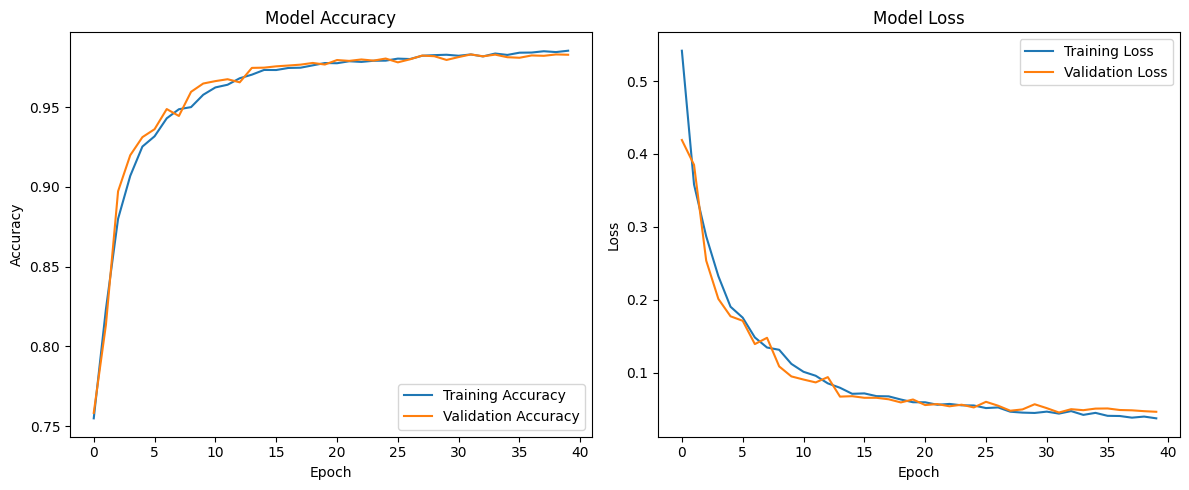

In [7]:
def plot_training_history(history):
    plt.figure(figsize=(12, 5))
    
    # Plot training & validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    
    # Plot training & validation loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

plot_training_history(history)